In [4]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from glob import glob
import warnings
import cv2
from skimage.color import rgb2gray

warnings.filterwarnings('ignore')
%matplotlib inline

import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [5]:
from pathlib import Path

if os.name == 'nt':
    file_path = 'C:\\JL\\Master\\DSE_I2100_Applied Machine Learning and Data Mining\\Final_Project\\lgg-mri-segmentation'
else:
    file_path = os.path.join(os.path.expanduser("~"), "Downloads/")

## Comment below if using outside of collab
#file_path='/'

In [10]:
file_path

'/Users/juanguerrero/Downloads/'

In [11]:
# Set parameters
Size = (256, 256)
mask_files = glob(file_path + os.path.join('kaggle_3m','*','*_mask*'))
train_files = [file.replace('_mask', '') for file in mask_files]

In [12]:
def label(mask):
    value = np.max(imread(mask))
    return '1' if value > 0 else '0'
df = pd.DataFrame({"image": train_files,
                   "mask": mask_files,
                  "label":[label(x) for x in mask_files]})

In [13]:
df.shape

(3929, 3)

In [14]:
df.head()

,image,mask,label
0,/Users/juanguerrero/Downloads/kaggle_3m/TCGA_C...,/Users/juanguerrero/Downloads/kaggle_3m/TCGA_C...,0
1,/Users/juanguerrero/Downloads/kaggle_3m/TCGA_C...,/Users/juanguerrero/Downloads/kaggle_3m/TCGA_C...,0
2,/Users/juanguerrero/Downloads/kaggle_3m/TCGA_C...,/Users/juanguerrero/Downloads/kaggle_3m/TCGA_C...,0
3,/Users/juanguerrero/Downloads/kaggle_3m/TCGA_C...,/Users/juanguerrero/Downloads/kaggle_3m/TCGA_C...,0
4,/Users/juanguerrero/Downloads/kaggle_3m/TCGA_C...,/Users/juanguerrero/Downloads/kaggle_3m/TCGA_C...,0


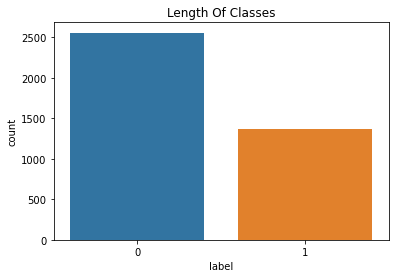

In [15]:
sns.countplot(data=df,x=df['label'])
plt.title('Length Of Classes')
plt.show()

In [16]:
from skimage.color import rgb2gray

image_dataset = []

for path in df["image"]:
  image_dataset.append(rgb2gray(cv2.imread(path)).reshape(-1))

image_dataset_np = np.array(image_dataset)


image_df = pd.DataFrame(image_dataset_np)

In [17]:
image_df.head()

,0,1,2,3,4,5,6,7,8,9,...,65526,65527,65528,65529,65530,65531,65532,65533,65534,65535
0,0.003639,0.003639,0.003639,0.003639,0.003639,0.003639,0.003639,0.003639,0.003639,0.003639,...,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833
1,0.003639,0.003639,0.003639,0.003639,0.003639,0.003639,0.003639,0.003639,0.003639,0.003639,...,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833
2,0.003639,0.003639,0.003639,0.003639,0.003639,0.003922,0.003922,0.003922,0.003922,0.003922,...,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833
3,0.003639,0.003639,0.003639,0.003639,0.003639,0.003639,0.003639,0.003639,0.003639,0.003639,...,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833
4,0.003639,0.003639,0.003639,0.003639,0.003639,0.003639,0.003639,0.003639,0.003639,0.003639,...,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833


In [18]:
from sklearn.model_selection import train_test_split

X = image_df
y = df.label

print(X.shape)
print(y.shape)
 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


(3929, 65536)
(3929,)


### Feature Selection

In [19]:
import numpy as np
from sklearn.decomposition import PCA

In [20]:
pca = PCA()

In [21]:
pca.fit(image_df)

PCA()

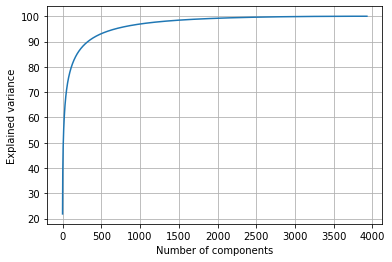

In [22]:
plt.grid()
plt.plot(np.cumsum(pca.explained_variance_ratio_*100))
plt.xlabel('Number of components')
plt.ylabel('Explained variance')
plt.show()

In [ ]:
pca_1000 = PCA(n_components=1000)
pca_reduced = pca_1000.fit_transform(image_df)
pca_recovered = pca_1000.inverse_transform(pca_reduced)

In [ ]:
img_pca_1000 = pca_recovered[1,:].reshape([256,256])
plt.show(img_pca_1000, cmap='gray_r')
plt.title()

In [ ]:
pca_2=PCA(n_components=.9)
value = pca_2.fit_transform(image_df)

### TODO's
- Research what other EDA techniques we can apply to the images
- Apply some sort of Visualization.
- Data Augmentation to balance images (Check for class imbalance)


### Resources
- [EDA for Image Classification](https://medium.com/geekculture/eda-for-image-classification-dcada9f2567a)
- [How to Do Data Exploration for Image Segmentation and Object Detection (Things I Had to Learn the Hard Way) | Neptune Blog](https://neptune.ai/blog/data-exploration-for-image-segmentation-and-object-detection)
- [Exploratory Data Analysis Ideas for Image Classification](https://towardsdatascience.com/exploratory-data-analysis-ideas-for-image-classification-d3fc6bbfb2d2)
- [4 Ways to Improve Class Imbalance for Image Data](https://towardsdatascience.com/4-ways-to-improve-class-imbalance-for-image-data-9adec8f390f1)



### Videos
- [Image classification using traditional machine learning](https://www.youtube.com/watch?v=nK-2k_ENgEc)
- [Working with imbalanced data during machine learning training](https://www.youtube.com/watch?v=kus4kmDhfdM)
- [Feature selection for speeding up machine learning training​](https://www.youtube.com/watch?v=xvmtpWGBLjI&list=PLHae9ggVvqPgyRQQOtENr6hK0m1UquGaG&index=93)
- [Deep Learning terminology explained - Data augmentation](https://www.youtube.com/watch?v=_bahDWWufCc&list=PLHae9ggVvqPgyRQQOtENr6hK0m1UquGaG&index=107)
- [Binary Classification using Deep Learning](https://www.youtube.com/watch?v=L-flsWk692E&list=PLHae9ggVvqPgyRQQOtENr6hK0m1UquGaG&index=114)
- [Binary semantic segmentation using U-Net (in Keras)](https://www.youtube.com/watch?v=oBIkr7CAE6g&list=PLHae9ggVvqPgyRQQOtENr6hK0m1UquGaG&index=122)

## Feature Selection

## Classification

### Evaluation and Conclusion

## Segmentation

### Evaluation and Conclusion